import libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import random

functions

In [2]:
def plot(accuracy, loss): # return schedule of accuracy and loss
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('epoch')

    ax1.set_ylabel('total loss')
    ax1.plot(loss,color='tab:red')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('accuracy')  
    ax2.plot( accuracy, color='tab:blue')
    ax2.tick_params(axis='y')
    fig.tight_layout()

In [3]:
def get_image_and_transform(path, dims=False, mode='grayscale'):
    
    data = utils.load_img(path, color_mode=mode, target_size=(50, 180))
    data = np.array(data)
    if dims:
        data = np.expand_dims(data, axis=0)
    data = data / 255.0
    return data

In [4]:
def build_dataset(dataset_dir, label, dims=False, mode='grayscale'): # build 2 list with array for training and 1 list with labels
    x_train1, x_train2, y_train = [], [], []
    classes = sorted(os.listdir(dataset_dir))
    for i in range(len(classes)):
        class_dir = os.path.join(dataset_dir, classes[i])
        images = os.listdir(class_dir)
        if len(images) == 1:
            continue
        if len(images) % 2 != 0:
            del images[len(images) - 1]
        for image in range(len(images)):
            full_image_path = os.path.join(class_dir, images[image])
            if 'ipynb_checkpoints' in full_image_path:
                continue
            if image < len(images)//2:
                y_train.append(label)
                x_train1.append(get_image_and_transform(full_image_path, dims, mode))
            else:
                x_train2.append(get_image_and_transform(full_image_path, dims, mode))
    return x_train1, x_train2, y_train

dataset

In [5]:
train_data = "/home/jovyan/dataset2/train"
train_wrong_data = "/home/jovyan/dataset2/test" 

train_data_1, train_data_2, train_labels1 = build_dataset(train_data, 1)
train_data_3, train_data_4, train_labels2 = build_dataset(train_wrong_data, 0)

random.shuffle(train_data_3)
random.shuffle(train_data_4)

train_data_1 = train_data_1 + train_data_3
train_data_2 = train_data_2 + train_data_4
train_labels1 = train_labels1 + train_labels2

train_data_1 = np.array(train_data_1)
train_data_2 = np.array(train_data_2)
train_labels1 = np.array(train_labels1)

# first implementation of siamese CNN

In [6]:
def siamese_model(in_1=32, in_2=32, in_3=32, in_4=64):
    input_shape = (50, 180, 1)
    
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)
    
    shared_layers = [
        Conv2D(filters=in_1, kernel_size=3, strides=1, padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(filters=in_2, kernel_size=3, strides=1, padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(filters=in_3, kernel_size=3, strides=1, padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(filters=in_4, kernel_size=3, strides=1, padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Flatten()
    ]
    
    fc_layers = [
        Dense(units=512, activation='tanh'),
        Dense(units=1, activation='sigmoid')
    ]
    
    output_1 = input_1
    output_2 = input_2
    for layer in shared_layers:
        output_1 = layer(output_1)
        output_2 = layer(output_2)
    
    concatenated = tf.keras.layers.Concatenate()([output_1, output_2])
    for layer in fc_layers:
        concatenated = layer(concatenated)
    
    siamese_model = Model(inputs=[input_1, input_2], outputs=concatenated)
    siamese_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return siamese_model
model1 = siamese_model()
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 180, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, 50, 180, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 50, 180, 32)  320         ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [ ]:
history = model1.fit([train_data_1, train_data_2], train_labels1, epochs=10)

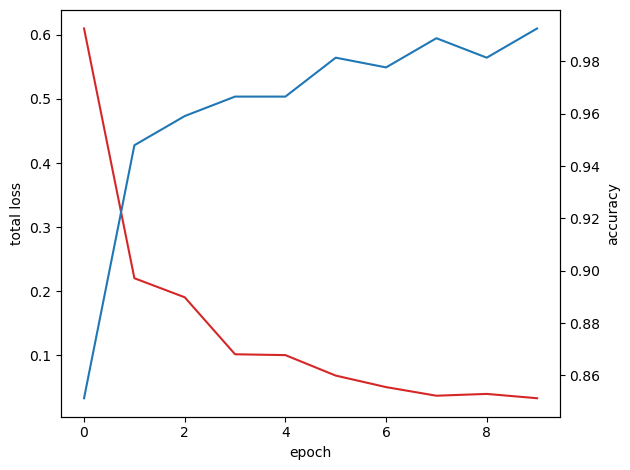

In [8]:
plot(history.history['accuracy'], history.history['loss'])

In [20]:
def predict_siamese_model(siamese_model, data_1, data_2):
    predictions = siamese_model.predict([data_1, data_2])
    return predictions, float(predictions) > 0.5

img1 = get_image_and_transform('/home/jovyan/21.jpg', True)
img2 = get_image_and_transform('/home/jovyan/11.jpg', True)

predict_siamese_model(model1,img1, img2)

1/1 [==============================] - 0s 20ms/step


(array([[0.03769164]], dtype=float32), False)

# second implementation of siamese CNN


In [11]:
train_data = "/home/jovyan/dataset2/train"
train_wrong_data = "/home/jovyan/dataset2/test" 

train_data_1, train_data_2, train_labels1 = build_dataset(train_data, 1,False, 'rgb')
train_data_3, train_data_4, train_labels2 = build_dataset(train_wrong_data, 0,False, 'rgb')

random.shuffle(train_data_3)
random.shuffle(train_data_4)

train_data_1 = train_data_1 + train_data_3
train_data_2 = train_data_2 + train_data_4
train_labels1 = train_labels1 + train_labels2

train_data_1 = np.array(train_data_1)
train_data_2 = np.array(train_data_2)
train_labels1 = np.array(train_labels1)

In [12]:
def siamese_model2(in_1=32, in_2=32, in_3=32, in_4=64):
    input_shape = (50, 180, 3)
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)
    
    base_model = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_top=False, input_shape=input_shape)
    
    fc_layers = [
        Dense(units=512, activation='tanh'),
        Dense(units=1, activation='sigmoid')
    ]
    
    
    output_1 = base_model(input_1)
    output_2 = base_model(input_2)
    
    flattened_1 = Flatten()(output_1)
    flattened_2 = Flatten()(output_2)
    
    concatenated = tf.keras.layers.Concatenate()([flattened_1, flattened_2])
    for layer in fc_layers:
        concatenated = layer(concatenated)
    
    siamese_model = Model(inputs=[input_1, input_2], outputs=concatenated)
    siamese_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return siamese_model

model2 = siamese_model2()
model2.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 50, 180, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 input_4 (InputLayer)           [(None, 50, 180, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 MobilenetV3small (Functional)  (None, 2, 6, 576)    939120      ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

In [ ]:
history = model2.fit([train_data_1, train_data_2], train_labels1, epochs=10)

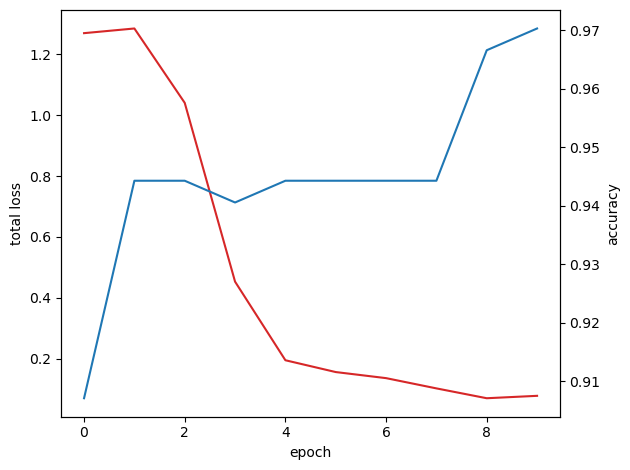

In [14]:
plot(history.history['accuracy'], history.history['loss'])

In [15]:
def predict_siamese_model(siamese_model, data_1, data_2):
    predictions = siamese_model.predict([data_1, data_2])
    return predictions, float(predictions) > 0.5

img1 = get_image_and_transform('/home/jovyan/11.jpg', True, 'rgb')
img2 = get_image_and_transform('/home/jovyan/22.jpg', True, 'rgb')

predict_siamese_model(model2,img1, img2)

1/1 [==============================] - 1s 1s/step


(array([[0.9310244]], dtype=float32), True)